# 2 {-}

**In this problem, we will revisit the Hope heights problem of HW 3, but this time we will use EM. Recall, we consider the two component Gaussian mixture model,**

$$ X=\begin{cases} 
      \mathcal{N}(\mu_1, \sigma_1^2) & \text{with probability}~p_1 \\
      \mathcal{N}(\mu_2, \sigma_2^2) & \text{with probability}~1-p_1 
   \end{cases}
$$

**where $\mathcal{N}(\mu, \sigma^2)$ is the normal distribution and $X$ models the height of a person when gender is unknown. Let $\hat{X}_1, \hat{X}_2,\ldots , \hat{X}_N$ be the sample heights given in the file.**

# a {-}

**Take a hard EM approach and compute the parameters of the model.**


The log likelihood of our data is:

$$\ell(\theta; x_1, x_2, \ldots, x_n)=\sum_{i=1}^{N}\log(p_1\frac{1}{\sqrt{2\pi \sigma_1^2}}e^{-\frac{(x_i-\mu_1)^2}{2\sigma_1^2}}+(1-p_1)\frac{1}{\sqrt{2\pi \sigma_2^2}}e^{-\frac{(x_i-\mu_2)^2}{2\sigma_2^2}})$$

$$=\sum_{i=1}^{N}\log(p_1\mathcal{N}(\mu_1, \sigma_1^2)|_{x_i}+(1-p_1)\mathcal{N}(\mu_2, \sigma_2^2)|_{x_i})$$

where the $\mathcal{N}(\mu_1, \sigma_1^2)|_{x_i}$ notation means the value of the density of a normal random variable with mean $\mu_1$ and variance $\sigma_1^2$ evaluated at the point $x_i$.

In [104]:
def logl(mu_1, mu_2, sigma_1, sigma_2, p1):
    logl = sum(np.log(p1*norm.pdf(x, loc=mu_1, scale=np.sqrt(sigma_1)) + (1-p1)*norm.pdf(x, loc=mu_2, scale=np.sqrt(sigma_2))))
    return logl

In [105]:
def hardEM(mu1, mu2, sigma1, sigma2, p1):  
    # E step
    def E_step(mu1, mu2, sigma1, sigma2, p1):
        denom = p1*norm.pdf(x, loc=mu1, scale=np.sqrt(sigma1)) + \
                (1-p1)*norm.pdf(x, loc=mu2, scale=np.sqrt(sigma2))
        num = p1*norm.pdf(x, loc=mu1, scale=np.sqrt(sigma1))               
        z = np.multiply(num, 1/denom)
        # in hard EM you are choosing the max
        z = np.where(z>=0.5, 1, 2)
        return z
    
    # M step
    def M_step(z):
        mu1 = x[z==1].mean()
        mu2 = x[z==2].mean()
        sigma1 = x[z==1].var()
        sigma2 = x[z==2].var()
        p1 = (z==1).sum()/len(x)
        return [mu1, mu2, sigma1, sigma2, p1]
    
    z = E_step(mu1, mu2, sigma1, sigma2, p1)
    return M_step(z) 

def hardEMfunction(theta, eps=10**-4, max_iter=10**5):
    i = 1
    l = logl(*theta)
    while(abs(l - logl(*hardEM(*theta))) > eps and i <= max_iter):
        theta = hardEM(*theta)
        l = logl(*theta)
        i += 1
    return theta

In [106]:
import pandas as pd
from scipy.stats import norm, multivariate_normal
import numpy as np

data = pd.read_csv("../HW3/Hope Heights.txt", sep='\s+').to_numpy()
data.shape
x = data[:, 1]
y = data[:, 0]
print(data.shape, x.shape, y.shape)

(100, 2) (100,) (100,)


The parameters of the model given the below starting point are

In [107]:
theta = [66, 73, 4, 1, 0.7]
theta_star = hardEMfunction(theta)
theta_star

[66.62711864406779,
 73.41463414634147,
 7.250790002872736,
 3.1695419393218325,
 0.59]

In [108]:
def classify(cutoff, theta_star):
    num = theta_star[-1]*norm.pdf(x, theta_star[0], np.sqrt(theta_star[2]))
    den = 1/(theta_star[-1]*norm.pdf(x, theta_star[0], np.sqrt(theta_star[2])) \
    + (1-theta_star[-1])*norm.pdf(x, theta_star[1], np.sqrt(theta_star[3]))) 
    p = np.multiply(num, den)
    return np.where(p > cutoff, 1, 2)

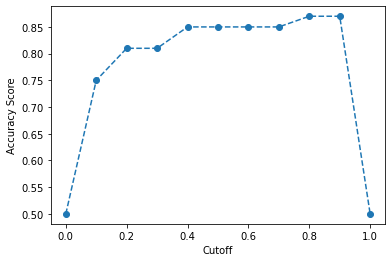

In [109]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

accuracies = [accuracy_score(y_true=y, y_pred=classify(p, theta_star)) for p in np.arange(0,1.1,0.1)]
plt.plot(np.arange(0,1.1,0.1), accuracies, "o--")
plt.xlabel("Cutoff")
plt.ylabel("Accuracy Score")
plt.show()

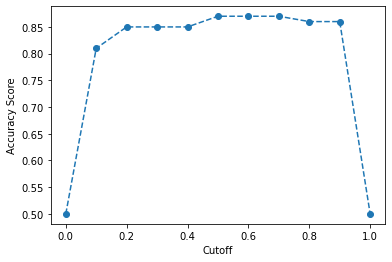

In [110]:
# try another starting point
theta = [67, 74, 1, 3, 0.2]
theta_star = hardEMfunction(theta)
theta_star

accuracies = [accuracy_score(y_true=y, y_pred=classify(p, theta_star)) for p in np.arange(0,1.1,0.1)]
plt.plot(np.arange(0,1.1,0.1), accuracies, "o--")
plt.xlabel("Cutoff")
plt.ylabel("Accuracy Score")
plt.show()

# b {-}

**Take a soft EM approach and compute the parameters of the model. Compare to your results in (a).**

In [111]:
def softEM(mu1, mu2, sigma1, sigma2, p1): 
    
    # E step
    def E_step(mu1, mu2, sigma1, sigma2, p1):
        denom = p1*norm.pdf(x, loc=mu1, scale=np.sqrt(sigma1)) + \
                (1-p1)*norm.pdf(x, loc=mu2, scale=np.sqrt(sigma2))
        num = p1*norm.pdf(x, loc=mu1, scale=np.sqrt(sigma1))               
        z = np.multiply(num, 1/denom)
        return z
    
    # M step
    def M_step(z):
        mu1 = sum(np.multiply(z, x))/sum(z)
        mu2 = sum(np.multiply(1-z, x))/sum(1-z)
        sigma1 = sum(np.multiply(z, (x-mu1)**2))/sum(z)
        sigma2 = sum(np.multiply(1-z, (x-mu2)**2))/sum(1-z)
        p1 = sum(z)/len(x)
        return [mu1, mu2, sigma1, sigma2, p1]
    
    z = E_step(mu1, mu2, sigma1, sigma2, p1)
    return M_step(z) 

def softEMfunction(theta, eps=10**-4, max_iter=10**5):
    i = 1
    l = logl(*theta)
    while(abs(l - logl(*softEM(*theta))) > eps and i <= max_iter):
        theta = softEM(*theta)
        l = logl(*theta)
        i += 1
    return theta

The parameters given a starting point are

In [122]:
theta = [66, 73, 4, 1, 0.7]
theta_star = softEMfunction(theta)

[66.55465573386884,
 73.35675297458064,
 7.030979074329778,
 3.5066957743092066,
 0.6132527988737133]

The parameters change slightly when using SoftEM, still reasonably close to what is obtained with HardEM (note, using same initialization for comparison purposes).

# c  {-}

**Given your parameters in (b), use the distribution of $X$ to predict whether a given sample is taken from a man or woman. Determine what percentage of individuals are classified correctly.**


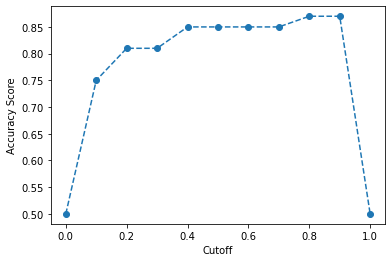

In [123]:
accuracies = [accuracy_score(y_true=y, y_pred=classify(p, theta_star)) for p in np.arange(0,1.1,0.1)]
plt.plot(np.arange(0,1.1,0.1), accuracies, "o--")
plt.xlabel("Cutoff")
plt.ylabel("Accuracy Score")
plt.show()

# 3 {-}

**Attached you will find the file TimeSeries.csv. The file contains a $1000 \times 20$ matrix. Each row represents a sample of a random vector $X \in R^{20}$, but $X$ represents time series data, so that $X_1, X_2, . . . , X_{20}$ represent measurements at times $1, 2, . . . , 20$, respectively. Often, we have a collection of time series samples and would like to separate the samples into similar groups, i.e. cluster. Here we’ll do this by using a multivariate normal mixture model.**

**To visualize the data, produce a line plot of each sample.**

In [133]:
data = pd.read_csv('TimeSeries.csv')
ts = data.to_numpy()
bs = pd.read_csv('BaseSeries.csv')
ts.shape

(1000, 20)

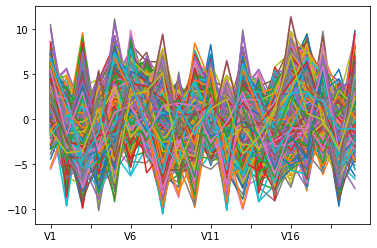

In [125]:
data.T.plot(legend=None)
plt.show()

The time series are not easy to distinguish. 

**The data is based on $4$ underlying time series found in the file __BaseSeries.csv__ which contains a $4 \times 20$ matrix. How was the data generated?**

Each base time series was created by sampling from a uniform random variable between $-5$ and $5$ and then tweaking a bit by susbtituting with $0$'s particular indices. Each row in the TimeSeries csv file was generated by choosing one of the $4$ base time series and adding some noise (normal with mean $0$ and standard deviation $2$). Plots of the base time series are shown later on.

**Now assume the following model for $X$:**

$$ X=\begin{cases} 
      \mathcal{N}(\mu^{(1)}, \Sigma^{(1)}) & \text{with probability}~p_1 \\
      \mathcal{N}(\mu^{(2)}, \Sigma^{(2)}) & \text{with probability}~p_2  \\
      \vdots \\
      \mathcal{N}(\mu^{(k)}, \Sigma^{(K)}) & \text{with probability}~p_K
   \end{cases}
$$

**Each of the $\mu^{(i)} \in R^{20}$ and each $\Sigma^{(i)}$ is a $20 \times 20$ covariance matrix. $K$ is the number of mixtures, which we must choose. (In this case, since you know the solution, you can set $K = 4$.)**

# a  {-}

**To fit this model using EM, you need to know how to derive the MLE of a multivariate normal. Let $Z$ be an $n$-dimensional multivariate normal with mean $\mu$ and covariance matrix $\Sigma$. Let $\hat{Z}^{(i)}$ be iid samples from $Z$ for $i = 1,2,...,N$. Write down the log-likelihood and use it to show that the MLE estimate $\hat{\mu}$ of $\mu$ is given by the sample mean of the $\hat{Z}^{(i)}$. Then read Chis Murphy’s section $4.1.3$ of the book Machine Learning (attached) and in your own words summarize the steps needed to derive the MLE for the variance (or derive it yourself if you prefer). (Bishop does not include the derivation in his book.)**

Attached.

# b  {-}


**Take a hard EM approach to estimating the parameters of the model. When you stop your iteration, plot the $\mu^{(i)}$ and determine if you have recovered the underlying time series used to generate the data.**

In [126]:
def logl(mus, sigmas, ps):
    l = 0
    for i in range(k):
        l += multivariate_normal.pdf(ts, mean=mus[i], cov=sigmas[i])*ps[i]
    logl = np.log(l)
    return sum(logl)

In [127]:
def hardEM(z):  
    """ Hard EM algorithm
    
    Args:
        z: An array of shape (N, )
        
    Returns:
        A list with the following elements:
            1. theta: A list with the following elements
                    mus: Matrix of shape (k, 20) with k being the number of mixtures
                    sigmas: Matrix of shape (k, 20, 20) with k being the number of mixtures
                    ps: Matrix of shape (k,) with k being the number of mixtures
            2. The updated array z of shape (N, )
        
    """
    # E step
    def E_step(mus, sigmas, ps):
        mvn = multivariate_normal.pdf(ts, mean=mus[0], cov=sigmas[0])*ps[0]
        for i in range(1, k):
            mvn = np.vstack([mvn, multivariate_normal.pdf(ts, mean=mus[i], cov=sigmas[i])*ps[i]])
        z = np.argmax(mvn, axis=0)
        return z
    
    # M step
    def M_step(z):
        mus = ts[z==0].mean(axis=0)
        sigmas = (ts[z==0]-mus[0]).T.dot(ts[z==0]-mus[0])/ts[z==0].shape[0]
        ps = ts[z==0].shape[0]/ts.shape[0]
        for i in range(1, k):
            mus = np.vstack((mus, ts[z==i].mean(axis=0)))
            sigmas = np.vstack((sigmas, (ts[z==i]-mus[i]).T.dot(ts[z==i]-mus[i])/ts[z==i].shape[0]))
            ps = np.vstack((ps, ts[z==i].shape[0]/ts.shape[0]))
    
        sigmas = sigmas.reshape(k, 20, 20)
        ps = ps.reshape(-1,)
        return [mus, sigmas, ps]
        
    theta = M_step(z) 
    return [theta, E_step(*theta)]

def hardEMfunction(z, eps=10**-4):
    """Function that runs the EM algorithm
    
    Args:
        z: An array of shape (N, )
        
    Returns:
        theta: A list with the following elements
            mus: Matrix of shape (k, 20) with k being the number of mixtures
            sigmas: Matrix of shape (k, 20, 20) with k being the number of mixtures
            ps: Matrix of shape (k,) with k being the number of mixtures
    
    """
    l = np.Inf
    while(abs(l - logl(*hardEM(z)[0])) > eps):
        theta, z = hardEM(z) 
        l = logl(*theta)
    return theta

In [129]:
# initializing EM algorithm by randomly initializing assignments
np.random.seed(2903)
N = ts.shape[0]
k = 4
z = np.random.choice(range(4), size=(N,))
theta, ls = hardEMfunction(z)

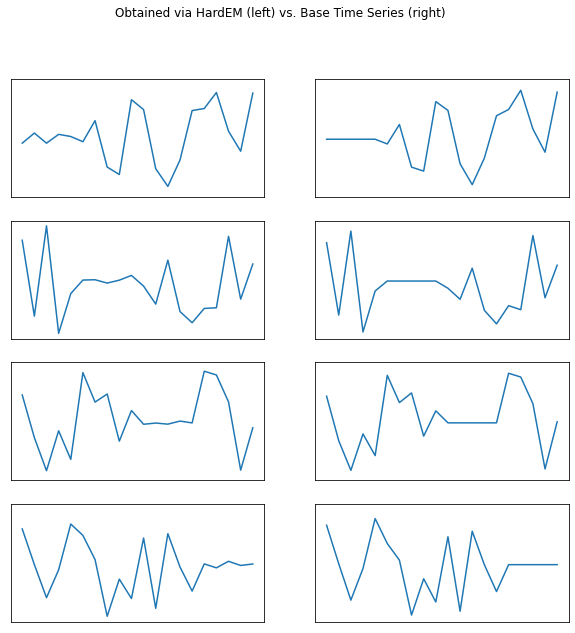

In [145]:
fig, axs = plt.subplots(4, 2, figsize=(10,10), sharex=True, sharey=True)

axs[0][0].plot(theta[0][0,:])
axs[1][0].plot(theta[0][1,:])
axs[2][0].plot(theta[0][2,:])
axs[3][0].plot(theta[0][3,:])

axs[0][1].plot(bs.loc[0, :])
axs[1][1].plot(bs.loc[1, :])
axs[2][1].plot(bs.loc[2, :])
axs[3][1].plot(bs.loc[3, :])

plt.xticks([])
plt.yticks([])
fig.suptitle('Obtained via HardEM (left) vs. Base Time Series (right)')
plt.show()

# c  {-}

**Now repeat, but take a soft EM approach. Compare your result to what you found using a hard EM approach.**

In [146]:
def softEM(z):  
    """ Soft EM algorithm
    
    Args:
        z: An array of shape (N, )
        
    Returns:
        A list with the following elements:
            1. theta: A list with the following elements
                    mus: Matrix of shape (k, 20) with k being the number of mixtures
                    sigmas: Matrix of shape (k, 20, 20) with k being the number of mixtures
                    ps: Matrix of shape (k,) with k being the number of mixtures
            2. The updated array z of shape (N, )
        
    """
    # E step
    def E_step(mus, sigmas, ps):
        mvn = multivariate_normal.pdf(ts, mean=mus[0], cov=sigmas[0])*ps[0]
        for i in range(1, k):
            mvn = np.vstack([mvn, multivariate_normal.pdf(ts, mean=means[i], cov=sigmas[i])*ps[i]])
        z = mvn/mvn.sum(axis=0)
    
    # M step
    def M_step(z):
        totals = z.dot(ts)
        mus = (1/z.sum(axis=1)).dot(totals)
        sigmas = np.multiply(ts-mus[0], z[0].reshape(-1,1)).T.dot(ts-mus[0])/sum(z[0])
        ps = sum(z[0])/ts.shape[0]
        for i in range(1, k):
            temp = np.multiply(ts-mus[i], z[i].reshape(-1,1)).T.dot(ts-mus[i])/sum(z[i])
            sigmas = np.vstack((sigmas, temp))
            ps = np.vstack((ps, sum(z[i])/ts.shape[0]))

        sigmas = sigmas.reshape(k, 20, 20)
        ps = ps.reshape(-1,)
        return [mus, sigmas, ps]
        
    theta = M_step(z) 
    return [theta, E_step(*theta)]

def softEMfunction(z, eps=10**-4):
    """Function that runs the EM algorithm
    
    Args:
        z: An array of shape (N, )
        
    Returns:
            1. theta: A list with the following elements
                    mus: Matrix of shape (k, 20) with k being the number of mixtures
                    sigmas: Matrix of shape (k, 20, 20) with k being the number of mixtures
                    ps: Matrix of shape (k,) with k being the number of mixtures
            2. ls: a list with the log likelihood value of each iteration i
    
    """
    l = np.Inf
    while(abs(l - logl(*softEM(z)[0])) > eps):
        theta, z = softEM(z) 
        l = logl(*theta)
    return theta

In [147]:
theta = softEMfunction(z)

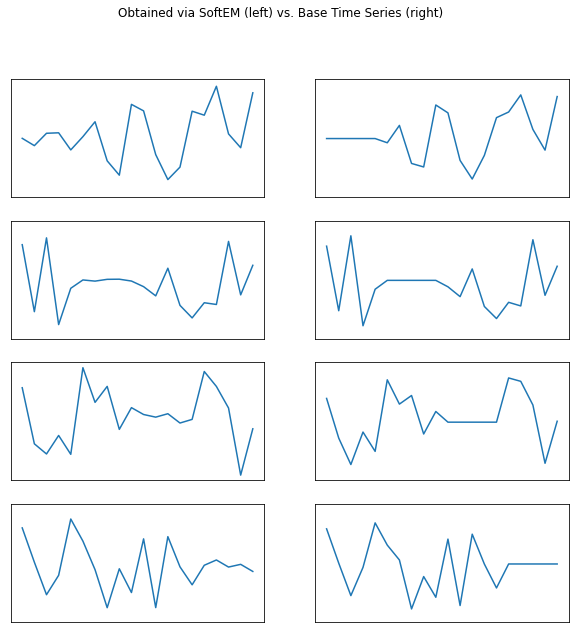

In [150]:
fig, axs = plt.subplots(4, 2, figsize=(10,10), sharex=True, sharey=True)

axs[0][0].plot(theta[0][0,:])
axs[1][0].plot(theta[0][1,:])
axs[2][0].plot(theta[0][2,:])
axs[3][0].plot(theta[0][3,:])

axs[0][1].plot(bs.loc[0, :])
axs[1][1].plot(bs.loc[1, :])
axs[2][1].plot(bs.loc[2, :])
axs[3][1].plot(bs.loc[3, :])

plt.xticks([])
plt.yticks([])
fig.suptitle('Obtained via SoftEM (left) vs. Base Time Series (right)')
plt.show()

It seems like SoftEM does slightly worse than HardEM. It is not too noticeable except for those characteristic parts of the base time series which are zeroed out (the HardEM is able to pick them up but SoftEM is not that capable -- Note I used the same initialization for both algorithms).

# 4 {-}

**Consider the hard core model on a $100 \times 100$ grid. Let $\Omega$ be the set of all configurations and $H$ the set of configurations that do not violate the hard-core restriction (no neighboring $1$’s). For $w \in \Omega$ let $f(w)$ be the number of positions with a $1$ in the grid.**

# a  {-}

**Let $X$ be the r.v. on $\Omega$,**

$$ P(X=w)=\begin{cases} 
      0 & \text{if}~w \notin H \\
      \frac{1}{|H|} &\text{if}~w\in H 
   \end{cases}
$$

**Using the Metropolis-Hasting algorithm, write a sampler for $X$. Show a sample configurations using the image function in R (or equivalent in Python). Using your sampler, generate a histogram for $f(X)/100^2$, the fraction of sites with a $1$ under the uniform distribution $X$. To decide how long to run the MH-algorithm before sampling, plot $f(X)$ as a function of the time step of your chain. If plotted on a long enough time scale, the plot should look noisy. Once you decide how long to run the chain, run the chain many times to produce a histogram. (Each time you sample from the Metropolis-Hastings algorithm you have to rerun the chain.)**

Let $w$ be our current configuration and $w'$ be the proposed configuration. The distribution we are interested in sampling from is the stationary distribution 

$$ v_{w}=P(X=w)=\begin{cases} 
      0 & \text{if}~w \notin H \\
      \frac{1}{|H|} &\text{if}~w\in H 
   \end{cases}
$$

Our proposal distribution is a symmetric proposal distribution, i.e., $q(w|w')=q(w'|w)=\frac{1}{100^2}$ (we generate a proposal by randomly selecting a row $i$ and column $j$ out of the $100$ rows and $100$ columns available -- then, flip the sign of $w_{ij}.$)

And so we have that the Metropolis-Hastings ratio is:

$$\min(1, \frac{v_{w'}q(w'|w)}{v_{w}q(w|w')})=\min(1, \frac{v_{w'}}{\frac{1}{|H|}}).$$

The above reduces to staying at configuration $w$ if $w'$ is not hardcore and moving to $w'$ if $w'$ is hardcore. 

In [63]:
def isHC(omega, n, i, j):
    """Function that checks if configuration is hardcore
    Args:
        omega: matrix of size (n, n)
        n: size of omega
        i: integer representing row of omega
        j: integer representing column of omega
        
    Returns:
        Boolean
    
    """
    if(omega[i, max(j-1, 0)] == 0
           and omega[i, min(j+1, n-1)] == 0
           and omega[max(i-1, 0), j] == 0
           and omega[min(i+1, n-1), j] == 0
          ):
        return True
    else:
        return False 

In [64]:
def MH_HardCore(omega, n):
    """Function that returns a sample of the hardcore model
    using Metropolis-Hastings
    
    Args:
        omega: matrix of size (n, n)
        n: size of omega
        
    Returns:
        omega: matrix of size (n, n)
    
    """
    i, j = np.random.randint(0, n, 2)
    if omega[i, j] == 1:
        omega[i, j] = 0
    else:
        if isHC(omega, n, i, j):
            omega[i, j] = 1
        else:
            pass
    return omega       

In [65]:
def MCMC_HardCore(N, omega):
    """MCMC using Metropolis-Hastings for Hardcore model
    
    Args:
        N: integer representing length of chain
        omega: matrix of size (n, n)
    
    Returns:
        n_ones: list of length N 
        omega: matrix of size (n, n)

    """
    n_ones = []
    for _ in range(N):
        n_ones.append(omega.sum()/n**2)
        omega = MH_HardCore(omega, n)
    return n_ones, omega

In [66]:
# hardcore initialization
n = 100
N = 10**5
omega_start = np.zeros((n, n))
n_ones, omega = MCMC_HardCore(N, omega_start)

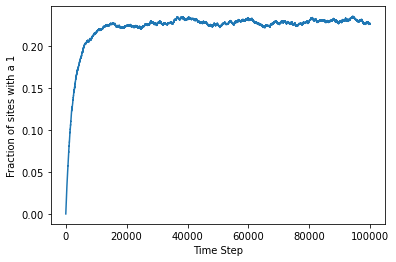

In [73]:
plt.plot(n_ones)
plt.xlabel("Time Step")
plt.ylabel("Fraction of sites with a 1")
plt.show()

From the above plot we can see indication of convergence after time step $20,000$, zooming in we can observe: 

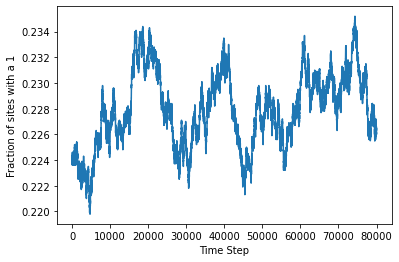

In [75]:
plt.plot(n_ones[20000:])
plt.xlabel("Time Step")
plt.ylabel("Fraction of sites with a 1")
plt.show()

Hence, running for $N=100,000$ is good enough. Lets plot a sample $w$ and visualize it:

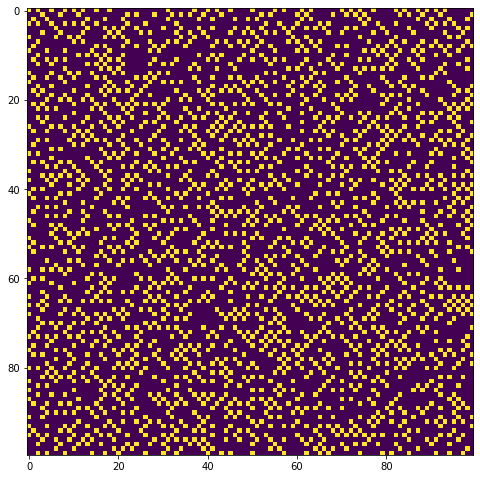

In [76]:
plt.figure(figsize=(8,10))
plt.imshow(omega)
plt.show()

Let's now run the chain $500$ times to get a histogram.

In [83]:
from progressbar import ProgressBar
pbar = ProgressBar()

In [84]:
samples = []
for _ in pbar(range(500)):
    chain, _ = MCMC_HardCore(N, omega_start)
    samples.append(chain[-1])

100% |########################################################################|


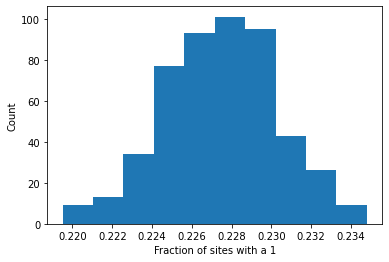

In [88]:
plt.hist(samples)
plt.xlabel("Fraction of sites with a 1")
plt.ylabel("Count")
plt.show()

# b  {-}

**Let $Y$ be the r.v. on $\Omega$ defined by $P(Y = w) = \alpha(f(w))^2$, where $\alpha$ is a normalizing constant that makes the probabilities sum to $1$. Use your sampler to generate a histogram for $f(Y)/100^2$. Compare to part a).**

Our proposal distribution will remain unchanged, however, our stationary distribution changes to $v_w=P(Y = w) = \alpha(f(w))^2$ and so our Metropolis-Hastings ratio becomes:

$$\min(1, \frac{v_{w'}q(w'|w)}{v_{w}q(w|w')})=\min(1, \frac{\alpha(f(w'))^2}{\alpha(f(w))^2})=\min(1, \frac{f(w')^2}{f(w)^2}).$$

Therefore, we move to configuration $w'$ if $\hat{u} < \min(1, \frac{f(w')^2}{f(w)^2})$ and stay at $w$ otherwise, where $\hat{u}$ is a sample from a uniform distribution between $0$ and $1$.

In [93]:
def MH_y(omega, n):
    """Function that returns a sample of the Y model
    using Metropolis-Hastings
    
    Args:
        omega: matrix of size (n, n)
        n: size of omega
        
    Returns:
        omega: matrix of size (n, n)

    """
    i, j = np.random.randint(0, n, 2)
    
    if omega[i, j] == 1:
        mh_ratio = min(1, ((omega.sum()-1)/omega.sum())**2)
    else:
        mh_ratio = min(1, ((omega.sum()+1)/omega.sum())**2)
        
    if(np.random.uniform(0,1) < mh_ratio):
        omega[i, j] = 1 - omega[i, j]
    
    return omega

In [94]:
def MCMC_y(N, omega):
    """MCMC using Metropolis-Hastings for Y model
    
    Args:
        N: integer representing length of chain
        omega: matrix of size (n, n)
    
    Returns:
        n_ones: list of length N 
        omega: matrix of size (n, n)

    """
    n_ones = []
    for _ in range(N):
        n_ones.append(omega.sum()/n**2)
        omega = MH_y(omega, n)
    return n_ones, omega

In [95]:
# Let's initialize using our omega found with MCMC_Hardcore
omega_start = omega
n_ones, omega = MCMC_y(N, omega_start)

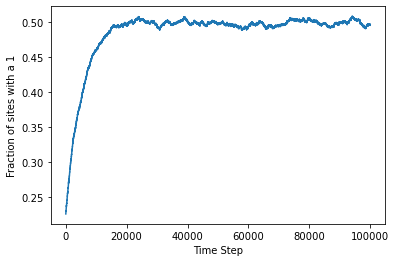

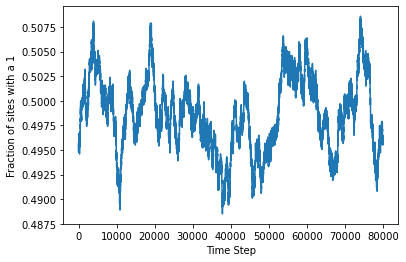

In [97]:
plt.plot(n_ones)
plt.xlabel("Time Step")
plt.ylabel("Fraction of sites with a 1")
plt.show()

plt.plot(n_ones[20000:])
plt.xlabel("Time Step")
plt.ylabel("Fraction of sites with a 1")
plt.show()

Hence, running for $N=100,000$ is good enough. Lets plot a sample $w$ and visualize it:

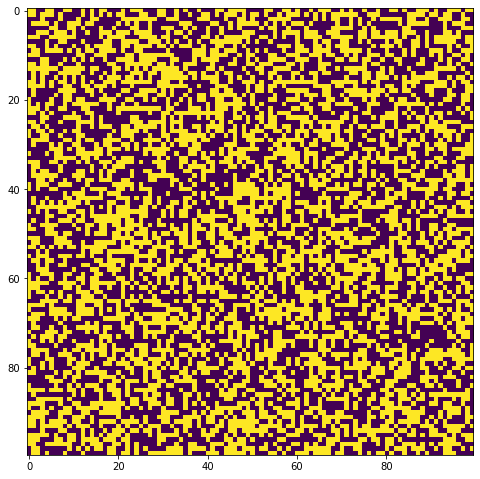

In [99]:
plt.figure(figsize=(8,10))
plt.imshow(omega)
plt.show()

Let's now run the chain $500$ times to get a histogram.

In [102]:
pbar = ProgressBar()
samples = []
for _ in pbar(range(500)):
    chain, _ = MCMC_y(N, omega_start)
    samples.append(chain[-1])

100% |########################################################################|


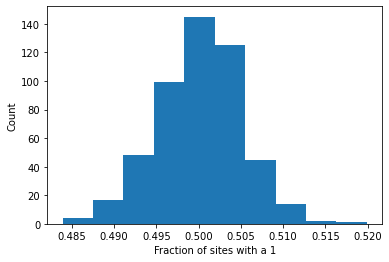

In [103]:
plt.hist(samples)
plt.xlabel("Fraction of sites with a 1")
plt.ylabel("Count")
plt.show()

Compared to part a) we can see that $Y$ allows for more configurations with $1$'s (the mean for $f(Y)/100^2$ is around $0.5$ whereas the mean for $f(X)/100^2$ is around $0.25$). This makes sense because the hard core model assumes the "hard core restriction," no neighboring $1$'s.

1
